# Relax Inc. Challenge

Relax Inc. makes productivity and project management software that's popular with both individuals and teams. For a concise write-up about the findings, see my [concluding thoughts](#5.-Conclusion). This exercise was time-capped at 2 hours.

1. [Constructing the Dependent Variable](#1.-Constructing-the-Dependent-Variable)
2. [Exploratory Data Analysis](#2.-Exploratory-Data-Analysis])
3. [Feature Engineering](#3.-Feature-Engineering)
4. [Modeling](#4.-Modeling)
5. [Conclusion](#5.-Conclusion)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier


In [2]:
users = pd.read_csv('takehome_users.csv', index_col='object_id')

users['opted_in_to_mailing_list'] = users.opted_in_to_mailing_list.astype('category')
users['enabled_for_marketing_drip'] = users.enabled_for_marketing_drip.astype('category')
users['org_id'] = users.org_id.astype('category')
users['creation_source'] = pd.Categorical(users.creation_source, categories=['PERSONAL_PROJECTS', 'GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH'], ordered=False)

users['creation_time'] = pd.to_datetime(users.creation_time)
users['last_session_creation_time'] = pd.to_datetime(users.last_session_creation_time)
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   name                        12000 non-null  object        
 2   email                       12000 non-null  object        
 3   creation_source             12000 non-null  category      
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    12000 non-null  category      
 6   enabled_for_marketing_drip  12000 non-null  category      
 7   org_id                      12000 non-null  category      
 8   invited_by_user_id          6417 non-null   float64       
dtypes: category(4), datetime64[ns](2), float64(1), object(2)
memory usage: 641.0+ KB


In [3]:
def proportion_plot(data, x, hue, pos_index=1, pos_label='Adopted', neg_label='Non-Adopted', proportion_label='Proportion of Adopted Users', ax=None):
    proportions = data.groupby(x)[hue].value_counts(normalize=True) \
                                      .to_frame().rename(columns={hue: 'proportion'}) \
                                      .reset_index() \
                                      .sort_values(by='proportion', ascending=False)
    proportions = proportions[proportions[hue] == pos_index].set_index(x)

    if ax is None:
        f, ax = plt.subplots()

    sns.set_color_codes('pastel')
    sns.barplot(data=pd.DataFrame({x: proportions.index.unique(), 'value': np.ones(proportions.index.nunique())}), x='value', y=x, color='b', ax=ax, label=neg_label)
    sns.set_color_codes('muted')
    sns.barplot(data=proportions, x='proportion', y=proportions.index, color='b', ax=ax, label=pos_label, order=proportions.index)

    ax.legend(ncol=2, loc='lower right', frameon=True)
    ax.set(xlim=(0, 1), ylabel='', xlabel=proportion_label)
    return proportions


In [4]:
def stacked_count_plot(data, x, hue, pos_index=1, pos_label='Adopted', neg_label='Non-Adopted', count_label='Count of Adopted Users', ax=None):
    total_counts = data.groupby(x)[hue].count()
    positive_counts = data.groupby(x)[hue].value_counts() \
                                 .to_frame() \
                                 .rename(columns={hue: 'count'}) \
                                 .reset_index()
    positive_counts = positive_counts[positive_counts['is_adopted'] == pos_index].sort_values(by='count', ascending=False).set_index(x)
    
    total_counts = total_counts.reindex(positive_counts.index).reset_index().rename(columns={hue:'count'})
    
    if ax is None:
        f, ax = plt.subplots()

    sns.set_color_codes('pastel')
    sns.barplot(data=total_counts, x='count', y=positive_counts.index, color='b', ax=ax, label=neg_label, order=positive_counts.index)
    sns.set_color_codes('muted')
    sns.barplot(data=positive_counts, x='count', y=positive_counts.index, color='b', ax=ax, label=pos_label, order=positive_counts.index)

    ax.legend(ncol=2, loc='lower right', frameon=True)
    ax.set(ylabel='', xlabel=count_label)

In [5]:
def count_and_proportion_plot(data, x, hue, pos_index=1, pos_label='Adopted', neg_label='Non-Adopted', title=None, figsize=(12, 4)):
    f, axes = plt.subplots(1, 2, figsize=figsize)
    
    proportion_plot(data=data, x=x, hue=hue, pos_index=pos_index, pos_label=pos_label, neg_label=neg_label, ax=axes[0])
    stacked_count_plot(data=data, x=x, hue=hue, pos_index=pos_index, pos_label=pos_label, neg_label=neg_label, ax=axes[1])
    plt.suptitle(f'Proportion and Count Plots for {x}, grouped by {hue}' if title is None else title)
    plt.tight_layout()

In [6]:
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement['time_stamp'] = pd.to_datetime(engagement.time_stamp)
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


# 1. Constructing the Dependent Variable
We want to predict future user adoption, where an adopted user is defined as a user who has loggeed into the product on three separate days in at least one seven-day period.

In [7]:
def is_adopted_user(logins, unique_logins=3, interval_in_days=7):
    l = logins.drop_duplicates(subset='time_stamp', keep='first')
    return any(l.sort_values(by='time_stamp').groupby('user_id').time_stamp.diff(periods=unique_logins-1) <= timedelta(days=interval_in_days))

In [8]:
has_minimum_visits = engagement.groupby('user_id').time_stamp.count() >= 3
minimum_visits = has_minimum_visits[has_minimum_visits].index

In [9]:
minimum_engagement = engagement[engagement.user_id.isin(minimum_visits)]

In [10]:
is_adopted = minimum_engagement.groupby('user_id').apply(is_adopted_user)
is_adopted_index = is_adopted[is_adopted].index
users['is_adopted'] = 0
users.loc[is_adopted_index, 'is_adopted'] = 1

In [11]:
users.is_adopted.value_counts(normalize=True)

0    0.862
1    0.138
Name: is_adopted, dtype: float64

Adopted users only comprise 13.8% of the dataset, so we must keep that in mind when conducting our exploration.

# 2. Exploratory Data Analysis

We will firstly explore the dataset with little to no feature engineering. In the next section, we will develop new features and visualize them accordingly. 

## 2.1 Visits

In [12]:
engagement.user_id.nunique()

8823

In [13]:
f'It appears that only {round(engagement.user_id.nunique() / len(users) * 100, 2)}% of users have engagement history'

'It appears that only 73.52% of users have engagement history'

In [14]:
unengaged_users = users[~users.index.isin(engagement.user_id.unique())]
unengaged_users.last_session_creation_time.unique()

array(['NaT'], dtype='datetime64[ns]')

Naturally, every user that does not have engagement history also does not have a session for their last login. So, these accounts must have either been created manually and not touched ever since, created artificially, or had their engagement data lost or missing.

Since making a predict on future user adoption is still important for users with no engagement so far, we can construct two paths: total users and users with engagement data available.

In [15]:
engaged_users = users[users.index.isin(engagement.user_id.unique())]

In [16]:
engagement['year'] = engagement.time_stamp.dt.year
engagement['month'] = engagement.time_stamp.dt.month
engagement['day'] = engagement.time_stamp.dt.day

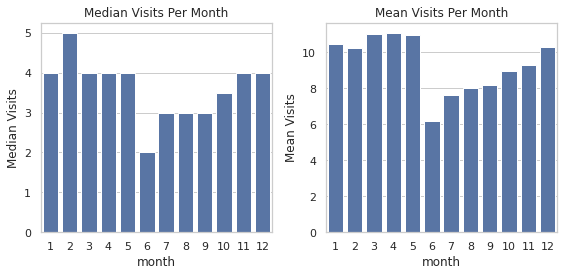

In [17]:
median_visits_per_month = engagement.groupby(['month', 'user_id']).visited.count().groupby('month').median()
mean_visits_per_month = engagement.groupby(['month', 'user_id']).visited.count().groupby('month').mean()
_, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.barplot(x=median_visits_per_month.index, y=median_visits_per_month, ax=axes[0], palette=(sns.color_palette()[0],));
sns.barplot(x=mean_visits_per_month.index, y=mean_visits_per_month, ax=axes[1], palette=(sns.color_palette()[0],));

axes[0].set_title('Median Visits Per Month')
axes[0].set_ylabel('Median Visits')
axes[1].set_title('Mean Visits Per Month')
axes[1].set_ylabel('Mean Visits')

plt.tight_layout()

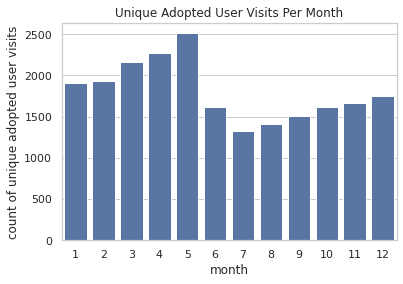

In [18]:
engagement_users = engagement.join(users, on='user_id')

def collapse_identity(rows):
    return int(rows.sum() >= 1)

unique_adopted_user_visits_per_month = engagement_users.groupby(['month', 'user_id']).is_adopted.agg(is_adopted=collapse_identity).groupby('month').is_adopted.count()

_, ax = plt.subplots()
sns.barplot(x=unique_adopted_user_visits_per_month.index, y=unique_adopted_user_visits_per_month, ax=ax, palette=(sns.color_palette()[0],));
ax.set_ylabel('count of unique adopted user visits');
ax.set_title('Unique Adopted User Visits Per Month');

The spring months March, April, and May seem to be popular times for adopted users to interact with the product.

## 2.2 Creation Source

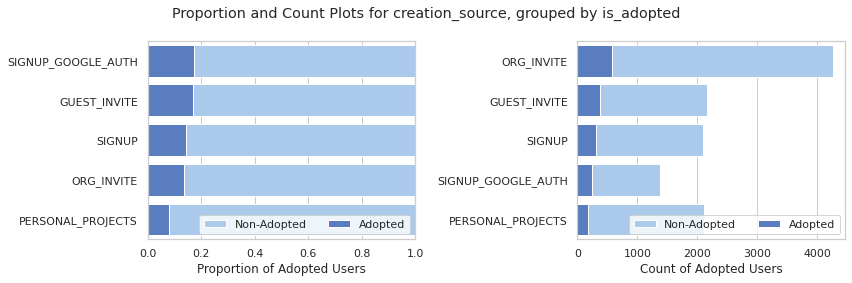

In [19]:
count_and_proportion_plot(data=users, x='creation_source', hue='is_adopted')

The top two creation sources by size are organizational and guest invites. Organizational invites dominate, which is mostly a function of its size, accounting for over 4000 rows in the dataset. Those who sign-up through Google authentication or are invited by a guest have the highest proportion of adopted users.

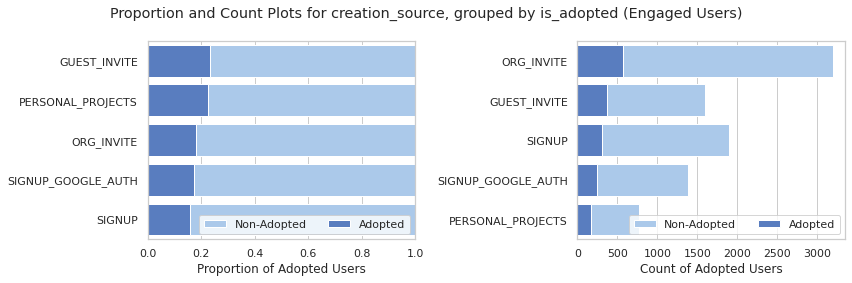

In [20]:
count_and_proportion_plot(data=engaged_users, x='creation_source', hue='is_adopted', title='Proportion and Count Plots for creation_source, grouped by is_adopted (Engaged Users)')

It appears that many of the unengaged users were sourced via personal projects, causing the proportion of adopted users in the personal projects category to increase noticeably upon their removal. We can confirm this here:

In [21]:
unengaged_users.creation_source.value_counts(normalize=True)

PERSONAL_PROJECTS     0.423985
ORG_INVITE            0.335537
GUEST_INVITE          0.180988
SIGNUP                0.059490
SIGNUP_GOOGLE_AUTH    0.000000
Name: creation_source, dtype: float64

Personal projects accounts for about 42.3% of all unengaged users.

## 2.3 Mailing List Opt-in

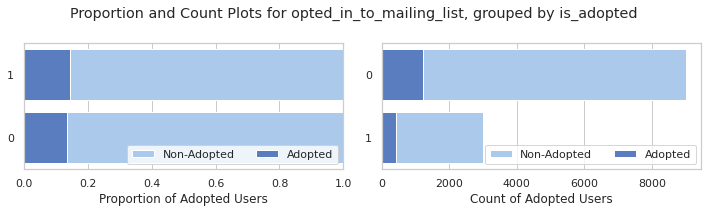

In [22]:
count_and_proportion_plot(data=users, x='opted_in_to_mailing_list', hue='is_adopted', figsize=(10, 3))

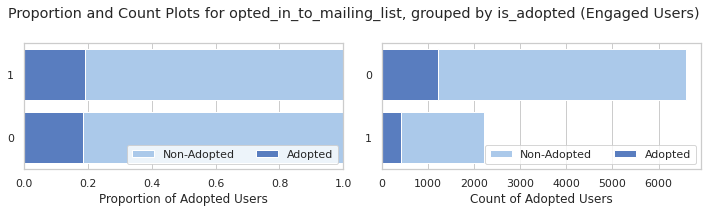

In [23]:
count_and_proportion_plot(data=engaged_users, x='opted_in_to_mailing_list', hue='is_adopted', figsize=(10, 3), title='Proportion and Count Plots for opted_in_to_mailing_list, grouped by is_adopted (Engaged Users)')

With and without unengaged users, the differences in the proportions of adopted users across mailing list opt-ins appears negligible.

## 2.4 Marketing Drip

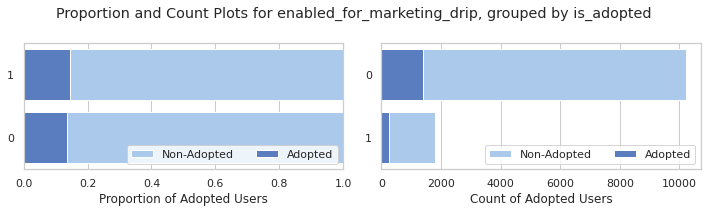

In [24]:
count_and_proportion_plot(data=users, x='enabled_for_marketing_drip', hue='is_adopted', figsize=(10, 3))

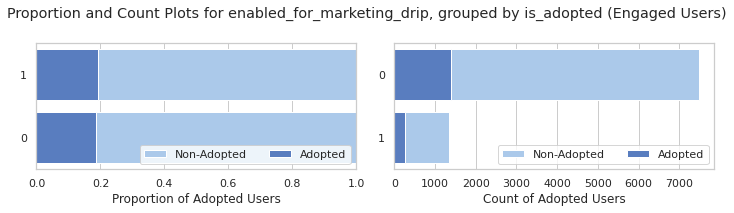

In [25]:
count_and_proportion_plot(data=engaged_users, x='enabled_for_marketing_drip', hue='is_adopted', figsize=(10, 3), title='Proportion and Count Plots for enabled_for_marketing_drip, grouped by is_adopted (Engaged Users)')

Similar to the above, the difference between the proportion of adopted users seems negligible.

# 3. Feature Engineering

## 3.1 Email Service Top-Level Domain
Users give their email address. We could extract the top-level domain to give us some idea of which countries these users are coming from.


In [26]:
# Extract only the domain service from their email address
users['email_service'] = users.email.str.split('@').str[1]

# Extract the top-level domain of the email address to see if country of origin may be predictive
users['email_tld'] = users.email.str.split('.').str[1]

# De-identify users
users = users.drop(columns=['name', 'email'])

In [27]:
users.groupby('is_adopted').email_tld.value_counts(normalize=True)

is_adopted  email_tld
0           com          0.897718
            de           0.102282
1           com          0.913043
            de           0.086957
Name: email_tld, dtype: float64

Only the .com and .de TLDs are used, with adopted users having a slightly higher proportion of .com users. 

## 3.2 Is the Inviting User An Adopted User?

In [28]:
users['was_invited'] = (~users.invited_by_user_id.isnull()).astype(int).astype('category')
engaged_users['was_invited'] = (~engaged_users.invited_by_user_id.isnull()).astype(int).astype('category')

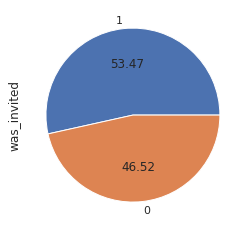

In [29]:
users.was_invited.value_counts(normalize=True).plot.pie(autopct='%.2f');

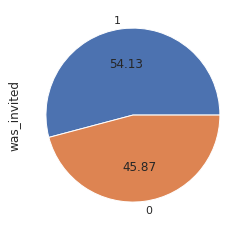

In [30]:
engaged_users.was_invited.value_counts(normalize=True).plot.pie(autopct='%.2f');

About 53% of users were invited by an existing user in the original data set and about 54% without unengaged users. 

In [31]:
def was_inviter_adopted(users):
    tmp = users.copy()
    tmp['was_inviter_adopted'] = 0
    tmp.loc[users.was_invited == 1, 'was_inviter_adopted'] = tmp[tmp.was_invited == 1].join(tmp.is_adopted.to_frame(), on='invited_by_user_id', how='left', rsuffix='_inviter').is_adopted_inviter
    tmp['was_inviter_adopted'] = tmp.was_inviter_adopted.astype('category')
    return tmp

In [32]:
users = was_inviter_adopted(users)
engaged_users = was_inviter_adopted(engaged_users)

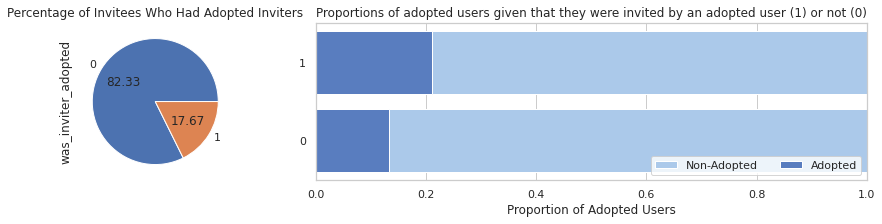

In [33]:
f = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = f.add_gridspec(1, 3)
axes = [f.add_subplot(gs[0, 0]), f.add_subplot(gs[0, 1:])]

users[users.was_invited == 1].was_inviter_adopted.value_counts(normalize=True).plot.pie(autopct='%.2f', ax=axes[0]);
p = proportion_plot(data=users[users.was_invited == 1], x='was_inviter_adopted', hue='is_adopted', ax=axes[1])

axes[0].set_title('Percentage of Invitees Who Had Adopted Inviters');
axes[1].set_title('Proportions of adopted users given that they were invited by an adopted user (1) or not (0)');

Only a small percentage of those who were invited to the platform were invited by adopted users at about 17.6%.

There is a noticeable difference between the proportion of adopted users in groups that had been invited by another adopted user (\~0.21) vs. those who had been invited by an unadopted user (\~13%).

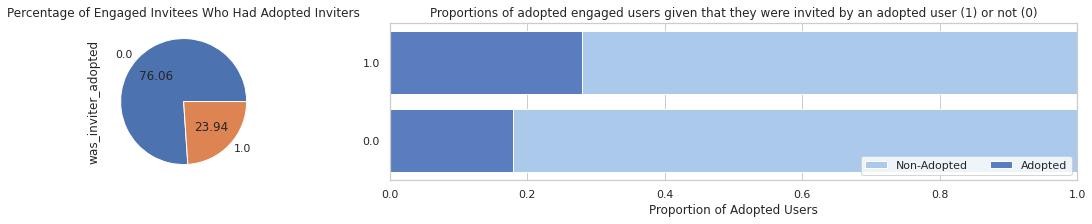

In [34]:
f = plt.figure(constrained_layout=True, figsize=(15, 3))
gs = f.add_gridspec(1, 3)
axes = [f.add_subplot(gs[0, 0]), f.add_subplot(gs[0, 1:])]

engaged_users[engaged_users.was_invited == 1].was_inviter_adopted.value_counts(normalize=True).plot.pie(autopct='%.2f', ax=axes[0]);
p = proportion_plot(data=engaged_users[engaged_users.was_invited == 1], x='was_inviter_adopted', hue='is_adopted', ax=axes[1])

axes[0].set_title('Percentage of Engaged Invitees Who Had Adopted Inviters')
axes[1].set_title('Proportions of adopted engaged users given that they were invited by an adopted user (1) or not (0)');

When singling out users who we have engagement history on, the proportion of adopted inviters increased from 17.6% tot 23.9%.

We see a starker difference between the proportion of adopted users for those who were and were not invited by an adopted user (~0.28 vs ~0.18), which is about 0.02 higher than the proportional difference computed on all users.

## 3.3 Organization Size
How large are the organization each user belongs to? Does the organization size contain some predictive information?


In [35]:
def org_size(users):
    s = users.reset_index().groupby('org_id').object_id.count().rename('org_size')
    return users.join(s, on='org_id', how='left')

In [36]:
users = org_size(users)
engaged_users = org_size(engaged_users)

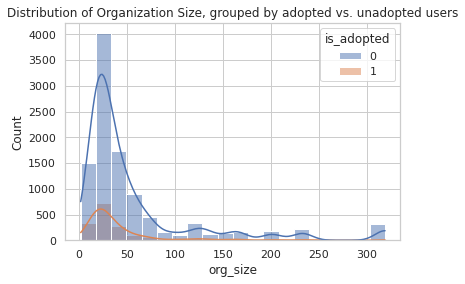

In [37]:
sns.histplot(data=users, x='org_size', bins=20, kde=True, hue='is_adopted');
plt.title('Distribution of Organization Size, grouped by adopted vs. unadopted users');

In [38]:
users.groupby('is_adopted').org_size.agg(['mean', 'median', 'count'])

,mean,median,count
is_adopted,,,
0,57.258604,30,10344
1,41.678140,27,1656


We observe that a large share of organizations are within the 0 to 50 range, creating a right-skewed distribution for both adopted and unadopted users. We see this reflected in summary statistics like the mean and median above.

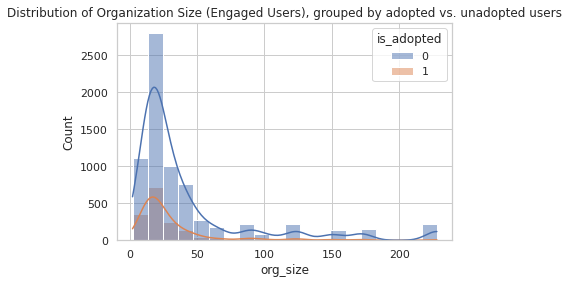

In [39]:
sns.histplot(data=engaged_users, x='org_size', bins=20, kde=True, hue='is_adopted');
plt.title('Distribution of Organization Size (Engaged Users), grouped by adopted vs. unadopted users');

In [40]:
engaged_users.groupby('is_adopted').org_size.agg(['mean', 'median', 'count'])

,mean,median,count
is_adopted,,,
0,42.479141,23,7167
1,30.733696,20,1656


Using only engaged users, we observe a large difference in the magnitude of the peak of the unadopted user distribution (all unengaged users are unadopted). We see this reflected in the mean and median.

## 3.4 Number of Logins

In [41]:
def num_logins(users):
    logins = engagement.groupby('user_id').visited.count().rename('num_logins')
    df = users.merge(logins, how='left', left_index=True, right_on='user_id')    
    df['num_logins'] = df['num_logins'].fillna(0)
    return df

In [42]:
users = num_logins(users)
engaged_users = num_logins(engaged_users)

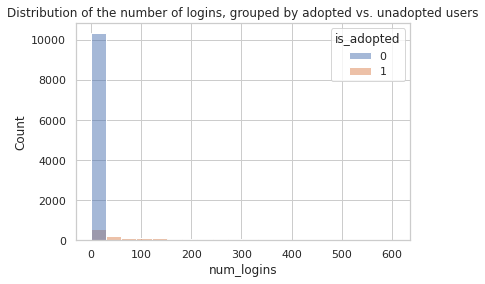

In [43]:
sns.histplot(data=users, x='num_logins', bins=20, hue='is_adopted');
plt.title('Distribution of the number of logins, grouped by adopted vs. unadopted users');

In [44]:
users.groupby('is_adopted').num_logins.agg(['mean', 'median', 'count'])

,mean,median,count
is_adopted,,,
0,0.927108,1.0,10344
1,119.762681,63.0,1656


Adopted users demonstrate a right-skewed distribution in the number of logins with its median at 63 logins, while unadopted users are dominated by those who have not interacted with the product at all, which is the number of unengaged users we've referenced prior.

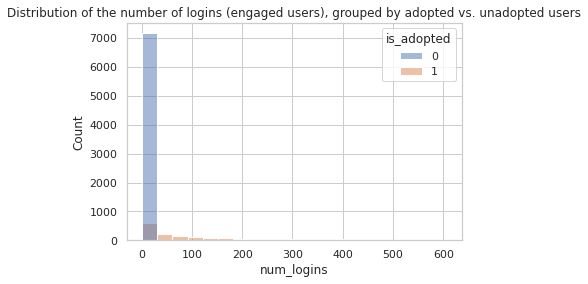

In [45]:
sns.histplot(data=engaged_users, x='num_logins', bins=20, hue='is_adopted');
plt.title('Distribution of the number of logins (engaged users), grouped by adopted vs. unadopted users');

In [46]:
engaged_users.groupby('is_adopted').num_logins.agg(['mean', 'median', 'count'])

,mean,median,count
is_adopted,,,
0,1.338077,1,7167
1,119.762681,63,1656


Even without these 3000 or so unengaged users, the distribution shape of unadopted users is unchanged and we still observe a large difference in the two groups' mean statistics.

This is an unsurprising result because the more times a user logs in, the more opportunities they have to fulfill the user adoption criteria of 3 logins within a week's time. This is a pretty vacuous observation, as it's similar to the claim that "a user who interacts with the product often has a high likelihood of interacting with the product often." It would be much more helpful if we could find an independent variable that allows us to predict user adoption prior to aggregating comprehensive user login data.

## 3.5 Organization Engagement
Are users in organizations with a high rate of engagement more likely to become an adopted user?

In [47]:
def org_login_rate(users):
    r = users.groupby(['org_id']).num_logins.agg(['mean']).rename(columns={'mean': 'org_login_rate'})
    df = users.merge(r, how='left', left_on='org_id', right_index=True)
    
    
    # Remove influence of the users number of logins
    df.loc[df.org_size > 1, 'org_login_rate'] = (df['org_login_rate'] * df.org_size - df.num_logins) / (df.org_size - 1)
    df.loc[df.org_size <= 1, 'org_login_rate'] = 0.

    return df

In [48]:
users = org_login_rate(users)

In [49]:
engaged_users = org_login_rate(engaged_users)

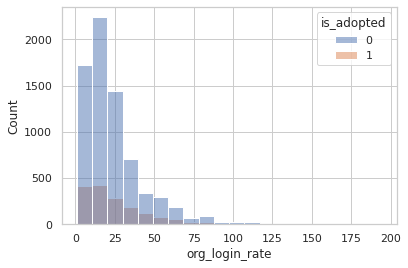

In [50]:
sns.histplot(data=engaged_users, x='org_login_rate', bins=20, hue='is_adopted');

In [51]:
engaged_users.groupby('is_adopted').org_login_rate.agg(['mean', 'median', 'count'])

,mean,median,count
is_adopted,,,
0,23.100599,17.447761,7167
1,25.576695,20.030725,1656


Adopted users, on average, belong to organizations that have a higher mean average login rate (excluding themselves).

## 5. Conclusion

This is a work-in-progress, as the modeling portion of this notebook has yet to be completed. However, below are some interesting findings so far:
 
- Only about 73% of users have a history of engagement with the product. Targeting why that engagement history is unavailable may help improve Relax's user adoption rate.
- Many of these "unengaged" users were created by being invited to join another user's personal workspace. Most of them also belong to organizations that are between 0 and 50 users.
- Adopted users tend to come from smaller organizations. This may make some sense in that a smaller organization is more tractable in ensuring that their employees use this product. Relax, Inc. may want to target smaller companies when performing their sales or marketing campaigns.
- The Spring months (March, April, May) yield more engagement from adopted users. This could imply seasonality, or that the company created a promotional for these months. 
- Only about 17 percent of users who were invited to the platform were invited by adopted users. This increases to about 24 percent when only considering engaged users. The proportional increase between users who have not been invited by an adopted and those who have is 0.02. To take advantage of this, the product can offer a higher incentive for referring other users.
- Naturally, the distribution of number of logins for adopted users is much higher that that of unadopted users. As mentioned, this is a vacuous observation and it would be more useful to find features that do not require a long history of login attempts from the user to make this prediction.
- Similarly, adopted users on average belong to organizations that have a higher mean average login rate (excluding themselves) (~23.1% vs ~25.5%)
- Opting into the mailing list or enabling the marketing drip do not seem to create a noticeable difference in adoption rate.

Based on the above, the most useful features so far appear to be organization size, organization login rate, months logged in, and whether the user was invited by an adopted user.


Next steps:
- Address class imbalance by either over-sampling the minority class (SMOTE) or randomly under-sampling the majority class.
- Remove low variance or correlated features and perform recursive feature selection to obtain a critical subset of features
- Run and evaluate baseline models
- Optimize hyperparameters